<a href="https://colab.research.google.com/github/DeepVein-AI/.github/blob/main/Blood_Vessels_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def fresnel(uz, n_i=1.4, n_t=1.0):
  if uz > 0:
    uz = -uz  # Incident from tissue to air
    cos_theta_i = -uz
    sin_theta_i = np.sqrt(1 - cos_theta_i**2)
    sin_theta_t = n_i / n_t * sin_theta_i
  if sin_theta_t > 1:
    return 1.0  # Total internal reflection
  cos_theta_t = np.sqrt(1 - sin_theta_t**2)
  rs = ((n_i * cos_theta_i - n_t * cos_theta_t) / (n_i * cos_theta_i + n_t * cos_theta_t))**2
  rp = ((n_i * cos_theta_t - n_t * cos_theta_i) / (n_i * cos_theta_t + n_t * cos_theta_i))**2
  return (rs + rp) / 2
# Computes the average Fresnel reflectance (for unpolarized light) at the interface between two media with refractive indices n_i (incident, default 1.4 for tissue)
# and n_t (transmitted, default 1.0 for air), given the z-component of the incident direction cosine uz. Handles total internal reflection if applicable.

In [ ]:
def henyey_greenstein(g, xi):
  if g == 0:
    return 2 * xi - 1
  else:
    cos_theta = (1 + g**2 - ((1 - g**2) / (1 - g + 2 * g * xi))**2) / (2 * g)
    return np.clip(cos_theta, -1, 1)  # Clamp for numerical stability
# Samples the cosine of the scattering angle using the Henyey-Greenstein phase function for anisotropic scattering,
# given anisotropy factor g and uniform random variable xi in [0,1]. Returns uniform cosine for isotropic case (g=0) and clamps result to [-1,1] for numerical stability.

In [ ]:
def update_direction(ux, uy, uz, theta, phi):
  sin_theta = np.sin(theta)
  cos_theta = np.cos(theta)
  sin_phi = np.sin(phi)
  cos_phi = np.cos(phi)
  if abs(uz) > 0.99999:
    ux_new = sin_theta * cos_phi
    uy_new = sin_theta * sin_phi
    uz_new = np.sign(uz) * cos_theta
  else:
    temp = np.sqrt(1.0 - uz**2 + 1e-10)  # Avoid zero
    ux_new = sin_theta * (ux * uz * cos_phi - uy * sin_phi) / temp + ux * cos_theta
    uy_new = sin_theta * (uy * uz * cos_phi + ux * sin_phi) / temp + uy * cos_theta
    uz_new = -sin_theta * cos_phi * temp + uz * cos_theta
  return ux_new, uy_new, uz_new
# Updates the direction cosines (ux, uy, uz) by deflecting them with polar angle theta and azimuthal angle phi,
# using a rotation formula that handles near-z-axis cases (abs(uz) > 0.99999) for numerical stability and adds a small epsilon to avoid division by zero.

In [ ]:
# Ray-cylinder intersection (infinite cylinder along y)
def ray_cylinder_intersection(x, z, ux, uz, cx, cz, radius):
  a = ux**2 + uz**2
  if a == 0:
    return None
  b = 2 * (ux * (x - cx) + uz * (z - cz))
  c = (x - cx)**2 + (z - cz)**2 - radius**2
  disc = b**2 - 4 * a * c
  if disc < 0:
    return None
  sqrt_disc = np.sqrt(disc)
  t1 = (-b - sqrt_disc) / (2 * a)
  t2 = (-b + sqrt_disc) / (2 * a)
  if t1 > t2:
    t1, t2 = t2, t1
  if t2 <= 0:
    return None
  t_entry = max(t1, 0.0)
  t_exit = t2
  if t_entry >= t_exit:
    return None
  return t_entry, t_exit
# Computes the entry and exit distances (t_entry, t_exit) along a ray starting at (x, z) with direction (ux, uz) that intersects an infinite cylinder centered at (cx, cz) with given radius,
# aligned along the y-axis. Solves quadratic equation for intersections and returns None if no valid forward intersection.

In [ ]:
def refract_direction(uz, n_i, n_t):
  sin_theta_i = np.sqrt(1 - uz**2 + 1e-10)
  sin_theta_t = (n_i / n_t) * sin_theta_i
  if sin_theta_t > 1:
    return -uz, 1.0  # Total reflection
  cos_theta_t = np.sqrt(1 - sin_theta_t**2)
  uz_new = np.sign(uz) * cos_theta_t
  scale = sin_theta_t / sin_theta_i
  return uz_new, scale
# Computes the refracted z-direction cosine (uz_new) and scale factor for transverse components (ux, uy) using Snell's law,
# given incident uz and refractive indices n_i to n_t. Returns reflected uz and scale=1.0 for total internal reflection; adds epsilon for numerical stability.

In [ ]:
def get_layer(z, z_bounds):
  for i in range(len(z_bounds)-1):
    if z_bounds[i] <= z < z_bounds[i+1]:
      return i
  return len(z_bounds) - 1  # Infinite layer
# Returns the layer index for a given z-coordinate by checking which interval in z_bounds it falls into, with the final layer extending infinitely if z is beyond the last bound.

In [ ]:
def get_current_props(layer_props, current_layer, inside_vessel, vessel_mu_a, vessel_mu_s, vessel_g):
  if inside_vessel:
    mu_a = vessel_mu_a
    mu_s = vessel_mu_s
    g = vessel_g
  else:
    curr = layer_props[current_layer]
    mu_a = curr['mu_a']
    mu_s = curr['mu_s']
    g = curr['g']
  mu_t = mu_a + mu_s
  albedo = mu_s / mu_t if mu_t > 0 else 0
  return mu_a, mu_s, g, mu_t, albedo
# Retrieves the current optical properties (absorption mu_a, scattering mu_s, anisotropy g, total attenuation mu_t, and albedo)
# based on whether the position is inside a vessel (using vessel-specific values) or in a tissue layer (from layer_props dictionary at current_layer index), with a safe albedo calculation to avoid division by zero.

In [ ]:
def monte_carlo(mu_a, mu_s, g, N=10000, threshold=0.001, m=10, num_bins=200, dz=0.01,
                use_vessel=False, L_v=0.5, r_v=0.05, vessel_mu_a=5.0, vessel_mu_s=50.0, vessel_g=0.95,
                use_layers=False, z_bounds=None, layer_props=None):
  if use_layers and (z_bounds is None or layer_props is None):
    use_layers = False
  if use_layers:
    num_layers = len(layer_props)
  else:
    num_layers = 1
    layer_props = [{'mu_a': mu_a, 'mu_s': mu_s, 'g': g, 'n': 1.4}]
    z_bounds = [0, np.inf]
  cx = 0.0
  cz = L_v
  radius = r_v
  reflectance = 0.0
  max_depths = []
  A = np.zeros(num_bins)
  for _ in range(N):
    x, y, z = 0.0, 0.0, 0.0
    ux, uy, uz = 0.0, 0.0, 1.0
    w = 1.0
    max_z = 0.0
    alive = True
    current_layer = get_layer(z, z_bounds)
    # step_count = 0  # Uncomment for debug
    while alive:
      # step_count += 1  # Uncomment for debug
      if w < threshold:
        if np.random.rand() < 1.0 / m:
          w *= m
        else:
          alive = False
          continue
      inside_vessel = use_vessel and ((x - cx)**2 + (z - cz)**2 < radius**2)
      mu_a, mu_s, g, mu_t, albedo = get_current_props(layer_props, current_layer, inside_vessel, vessel_mu_a, vessel_mu_s, vessel_g)
      if mu_t <= 0:
        alive = False
        continue
      xi = np.random.rand()
      tau = -np.log(xi + 1e-10)  # Avoid log(0)
      remaining_tau = tau
      while remaining_tau > 0 and alive:
        # Compute t to layer boundary
        layer_t = np.inf
        next_layer = current_layer
        if use_layers:
          if uz > 0:
            next_bound = z_bounds[current_layer + 1]
            next_layer = current_layer + 1
          else:
            next_bound = z_bounds[current_layer]
            next_layer = current_layer - 1
          layer_t = (next_bound - z) / uz if abs(uz) > 1e-6 else np.inf
          if layer_t <= 0:
            layer_t = np.inf
        # Compute t to vessel boundary
        vessel_t = np.inf
        if use_vessel:
          intersects = ray_cylinder_intersection(x, z, ux, uz, cx, cz, radius)
          if intersects is not None:
            t_entry, t_exit = intersects
            if inside_vessel:
              vessel_t = t_exit
            else:
              vessel_t = t_entry
        t_next = min(layer_t, vessel_t)
        if t_next <= 0:
          t_next = np.inf
        opt_next = mu_t * t_next
        if opt_next > remaining_tau:
          # Interaction before boundary
          s_rem = remaining_tau / mu_t
          x += s_rem * ux
          y += s_rem * uy
          z += s_rem * uz
          z = max(z, 0.0)  # Prevent floating-point underflow below 0
          if z > max_z:
            max_z = z
          dw = w * (mu_a / mu_t)
          bin_idx = int(z / dz)
          if 0 <= bin_idx < num_bins:
            A[bin_idx] += dw
          w *= albedo
          # Scatter
          xi1 = np.random.rand()
          cos_theta = henyey_greenstein(g, xi1)
          theta = np.arccos(cos_theta)
          phi = 2 * np.pi * np.random.rand()
          ux, uy, uz = update_direction(ux, uy, uz, theta, phi)
          uz = np.clip(uz, -1, 1)
          break
        else:
          # Move to boundary
          x += t_next * ux
          y += t_next * uy
          z += t_next * uz
          z = max(z, 0.0)  # Prevent floating-point underflow below 0
          if z > max_z:
            max_z = z
          remaining_tau -= opt_next
          if t_next == layer_t:
            # Handle layer boundary
            n_i = layer_props[current_layer]['n']
            if next_layer < 0 or next_layer >= num_layers:
              n_t = 1.0
            else:
              n_t = layer_props[next_layer]['n']
            R = fresnel(uz, n_i, n_t)
            if np.random.rand() < R:
              uz = -uz
            else:
              if next_layer < 0 or next_layer >= num_layers:
                reflectance += w
                max_depths.append(max_z)
                alive = False
                break
              else:
                uz, scale = refract_direction(uz, n_i, n_t)
                ux *= scale
                uy *= scale
                norm = np.sqrt(ux**2 + uy**2 + uz**2 + 1e-10)
                ux /= norm
                uy /= norm
                uz /= norm
                current_layer = next_layer
          else:
            # Handle vessel boundary
            inside_vessel = not inside_vessel
            inside_vessel = ((x - cx)**2 + (z - cz)**2 < radius**2)
          # Update properties after boundary handling
          mu_a, mu_s, g, mu_t, albedo = get_current_props(layer_props, current_layer, inside_vessel, vessel_mu_a, vessel_mu_s, vessel_g)
      # Update layer after step (in case z changed without layer boundary)
      current_layer = get_layer(z, z_bounds)
    # print(f"Photon {photon} steps: {step_count}")  # Uncomment for debug
  reflectance /= N
  if max_depths:
    avg_max_depth = np.mean(max_depths)
  else:
    avg_max_depth = 0.0
  A /= (N * dz)
  return reflectance, avg_max_depth, A
# Performs a Monte Carlo simulation of photon transport in semi-infinite or multi-layered tissue with optional embedded infinite cylindrical vessel along y-axis,
# computing total reflectance, average maximum depth of reflected photons, and depth-resolved absorption profile A (binned with dz resolution) using N photons;
# incorporates Russian roulette (threshold, m) for low-weight termination, boundary handling for layers (reflection/refraction via Fresnel/Snell) and vessel (ray-cylinder intersection),
# anisotropic scattering (Henyey-Greenstein), and numerical stability measures like clipping and epsilons.

In [ ]:
#result = monte_carlo(mu_a=0.25, mu_s=0.30, g=0.8, N=10000) # Large N for low-reflectance case
result = monte_carlo(mu_a=0.1, mu_s=20, g=0.9, N=10000, threshold=1e-5, m=100) # Large N for low-reflectance case
reflectance, avg_max_depth, A = result
print("Reflectance:", reflectance)
print("Average max depth:", avg_max_depth)
print("Absorption profile A (first 10 bins):", A[:10])

Reflectance: 0.0
Average max depth: 0.0
Absorption profile A (first 10 bins): [12.44934405  0.87129309  0.77155581  0.71269219  0.68163181  0.65858177
  0.63747957  0.63625927  0.61580587  0.60245712]


In [ ]:
# Example: Run with layers and vessel for illustration
z_bounds = [0, 0.2, np.inf]  # Layer 1: 0-0.2, Layer 2: 0.2+
layer_props = [
    {'mu_a': 0.1, 'mu_s': 10, 'g': 0.9, 'n': 1.4},
    {'mu_a': 0.5, 'mu_s': 20, 'g': 0.95, 'n': 1.3}
]
result = monte_carlo(mu_a=0.1, mu_s=10, g=0.9, N=1000,
                     use_layers=True, z_bounds=z_bounds, layer_props=layer_props,
                     use_vessel=True, L_v=0.5, r_v=0.05,
                     vessel_mu_a=5.0, vessel_mu_s=50.0, vessel_g=0.95,
                     dz=0.01, num_bins=200)
reflectance, avg_max_depth, A = result

UnboundLocalError: cannot access local variable 'sin_theta_t' where it is not associated with a value

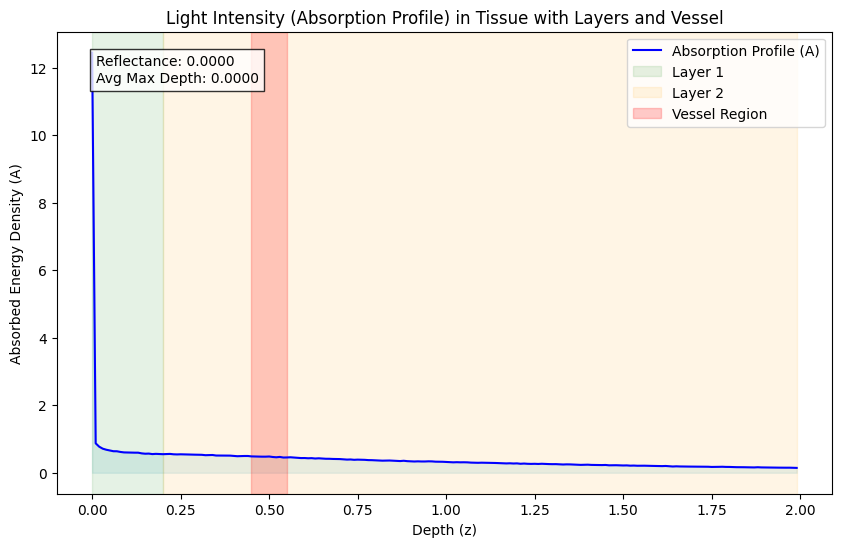

In [ ]:
# Plotting
depths = np.arange(len(A)) * 0.01  # dz=0.01
fig, ax = plt.subplots(figsize=(10, 6))

# Plot absorption profile with color gradient
ax.plot(depths, A, color='blue', label='Absorption Profile (A)')
ax.fill_between(depths, A, alpha=0.3, color='lightblue')

# Add layer boundaries as dashed lines
colors = ['green', 'orange']  # Colors for layers
for i in range(len(z_bounds) - 1):
  start = z_bounds[i]
  end = z_bounds[i+1] if np.isfinite(z_bounds[i+1]) else depths[-1]
  ax.axvspan(start, end, alpha=0.1, color=colors[i % len(colors)], label=f'Layer {i+1}')

# Add vessel as a shaded circle-like region (since 1D, shade the depth range)
vessel_center = 0.5  # L_v
vessel_radius = 0.05  # r_v
ax.axvspan(vessel_center - vessel_radius, vessel_center + vessel_radius,
           alpha=0.2, color='red', label='Vessel Region')

# Annotations for reflectance and avg max depth
ax.text(0.05, 0.95, f'Reflectance: {reflectance:.4f}\nAvg Max Depth: {avg_max_depth:.4f}',
        transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

ax.set_xlabel('Depth (z)')
ax.set_ylabel('Absorbed Energy Density (A)')
ax.set_title('Light Intensity (Absorption Profile) in Tissue with Layers and Vessel')
ax.legend()
plt.show()

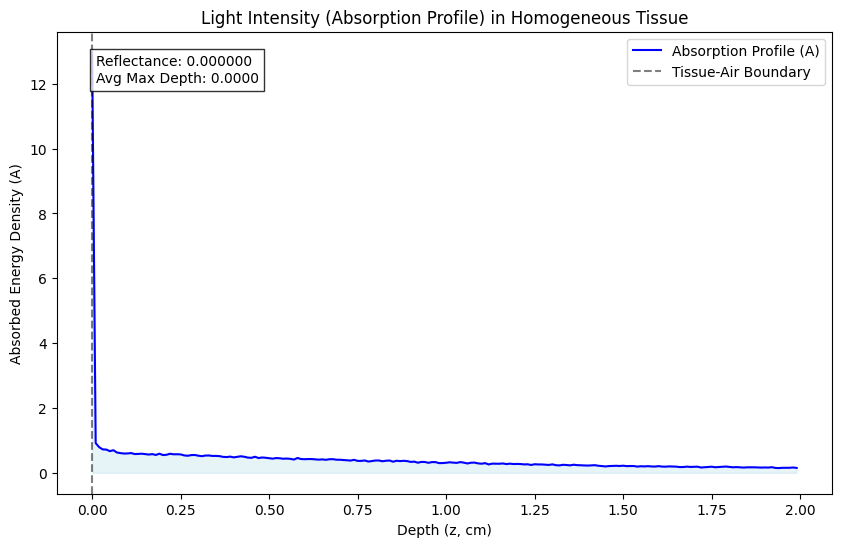

In [ ]:
# Plotting
depths = np.arange(len(A)) * 0.01  # dz=0.01
fig, ax = plt.subplots(figsize=(10, 6))

# Plot absorption profile with color gradient
ax.plot(depths, A, color='blue', label='Absorption Profile (A)')
ax.fill_between(depths, A, alpha=0.3, color='lightblue')

# Add boundary for tissue-air interface
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5, label='Tissue-Air Boundary')

# Annotations for reflectance and avg max depth
ax.text(0.05, 0.95, f'Reflectance: {reflectance:.6f}\nAvg Max Depth: {avg_max_depth:.4f}',
        transform=ax.transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

ax.set_xlabel('Depth (z, cm)')
ax.set_ylabel('Absorbed Energy Density (A)')
ax.set_title('Light Intensity (Absorption Profile) in Homogeneous Tissue')
ax.legend()
plt.show()